In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# Data Extraction

In [ ]:
def truncate_df(df: pd.DataFrame, columns:list):
    '''
    This function extracts the specified colums from given df
    '''
    valid_columns = []

    for col in columns:
        if col in df.columns:
            valid_columns.append(col)

    new_df = df[valid_columns]
    
    return new_df


# ------------------------------------------------------------------------------------------------------------------------------------------------------


def encode_extracted_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs one-hot encoding on specified columns while preserving the original column order.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    
    Returns:
    pd.DataFrame: The one-hot encoded dataframe with the original column structure preserved.
    """  
    # Columns to be one-hot encoded
    columns_to_encode = ["Heating Energy Source", "Vehicle Type", "Transport", "Waste Bag Size"]
    
    # Dictionary to store one-hot encoded columns
    encoded_dfs = {}
    
    # Perform one-hot encoding for each specified column individually
    for col in columns_to_encode:
        if col in df.columns:
            encoded_dfs[col] = pd.get_dummies(df[col], prefix='', prefix_sep='').astype(int)

    # Reconstruct the dataframe with the original order
    final_columns = []
    final_df = pd.DataFrame(index=df.index)  # Preserve original index

    for col in df.columns:
        if col in encoded_dfs:
            # Insert one-hot encoded columns in place of original column
            encoded_cols = encoded_dfs[col].columns
            final_df[encoded_cols] = encoded_dfs[col]
            final_columns.extend(encoded_cols)
        else:
            # Retain non-encoded columns in their original positions
            final_df[col] = df[col]
            final_columns.append(col)

    # Ensure final column order matches original structure with inserted encodings
    return final_df[final_columns]

#---------------------------------------------------------------------------------

def map_travel_frequency(df: pd.DataFrame) -> pd.DataFrame:
    """
    Maps the 'Frequency of Traveling by Air' column to numerical values.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    
    Returns:
    pd.DataFrame: The dataframe with the mapped 'Frequency of Traveling by Air' column.
    """
    mapping = {
        "never": 0,
        "rarely": 1,
        "frequently": 2,
        "very frequently": 3
    }
    if "Frequency of Traveling by Air" in df.columns:
        df["Frequency of Traveling by Air"] = df["Frequency of Traveling by Air"].map(mapping).fillna(df["Frequency of Traveling by Air"])
    return df

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def process_and_save(csv_file: str):
    """
    Reads a dataset from a CSV file, processes it, and saves the final dataframe to a specified GitHub repository directory.
    
    Parameters:
    csv_file (str): The path to the input CSV file.
    github_repo_path (str): The local path to the GitHub repository directory.
    extracted_columns (list): List of columns to extract from the dataframe.
    output_filename (str): Name of the output CSV file to be saved.
    """
    cwd = os.getcwd()
    
    # Read the dataset
    df = pd.read_csv(csv_file)

    extracted_columns = ['Heating Energy Source', 'Cooking_with', 'Transport', 'Vehicle Type','Vehicle Monthly Distance Km', 'Frequency of Traveling by Air', 'Waste Bag Size', 'Waste Bag Weekly Count','CarbonEmission']
    
    # Extract specified columns
    new_df = truncate_df(df, extracted_columns)
    
    # Map travel frequency column
    new_df = map_travel_frequency(new_df)
    
    # Perform one-hot encoding
    final_df = encode_extracted_data(new_df)

    # Rename Waste Bag Size encoded columns
    waste_bag_prefix = "Waste Bag Size"
    final_df.rename(columns={col: f"{col} waste bag" for col in final_df.columns if waste_bag_prefix in extracted_columns and col in new_df[waste_bag_prefix].unique()}, inplace=True)
    
    # Save the processed dataframe to CSV in the GitHub repo directory
    file_path = os.path.join(cwd, "Data_extraction/extracted_data_v1.csv")
    final_df.to_csv(file_path, index=False)

    print(f"Processed file saved at: {file_path}")


In [ ]:
# -------------------------------------------------------------------------------------

#Example usage of Data Extraction: 
process_and_save("Data_extraction/CarbonEmission.csv")

# Correlations

In [ ]:
# grab extracted data
data_dir = './data_extraction/'
csv_file = 'extracted_data_v1.csv'
filepath = os.path.join(data_dir, csv_file)
df = pd.read_csv(filepath)
df

,coal,electricity,natural gas,wood,private,public,walk/bicycle,diesel,electric,hybrid,lpg,petrol,Vehicle Monthly Distance Km,Frequency of Traveling by Air,extra large waste bag,large waste bag,medium waste bag,small waste bag,Waste Bag Weekly Count,CarbonEmission
0,1,0,0,0,0,1,0,0,0,0,0,0,210,2,0,1,0,0,4,2238
1,0,0,1,0,0,0,1,0,0,0,0,0,9,1,1,0,0,0,3,1892
2,0,0,0,1,1,0,0,0,0,0,0,1,2472,0,0,0,0,1,1,2595
3,0,0,0,1,0,0,1,0,0,0,0,0,74,1,0,0,1,0,3,1074
4,1,0,0,0,1,0,0,1,0,0,0,0,8457,3,0,1,0,0,1,4743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,1,0,0,0,0,1,0,0,268,0,0,0,1,0,5,2408
9996,1,0,0,0,1,0,0,0,0,0,1,0,5316,2,1,0,0,0,3,3084
9997,0,1,0,0,0,0,1,0,0,0,0,0,96,3,1,0,0,0,5,2377
9998,1,0,0,0,1,0,0,0,0,0,0,1,8688,1,0,0,1,0,5,4574


In [ ]:
# correlations between all data
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,coal,electricity,natural gas,wood,private,public,walk/bicycle,diesel,electric,hybrid,lpg,petrol,Vehicle Monthly Distance Km,Frequency of Traveling by Air,extra large waste bag,large waste bag,medium waste bag,small waste bag,Waste Bag Weekly Count,CarbonEmission
coal,1.000000,-0.340029,-0.331979,-0.332069,0.016532,-0.008855,-0.007583,0.014366,0.005252,-0.004675,0.010079,0.006329,0.014508,0.005956,-0.001994,-0.005318,0.002033,0.005269,-0.008915,0.128958
electricity,-0.340029,1.000000,-0.334531,-0.334621,-0.007232,0.004573,0.002624,-0.011144,-0.000219,0.007638,-0.005291,-0.004769,-0.001630,0.002872,-0.005297,0.005691,0.005653,-0.006008,0.000371,-0.132167
natural gas,-0.331979,-0.334531,1.000000,-0.326700,-0.013988,0.000502,0.013339,-0.006859,-0.002041,-0.008581,-0.001460,-0.007824,-0.016752,-0.021741,0.003485,-0.001472,0.011244,-0.013173,0.010431,-0.011807
wood,-0.332069,-0.334621,-0.326700,1.000000,0.004639,0.003796,-0.008348,0.003653,-0.003031,0.005563,-0.003346,0.006269,0.003774,0.012829,0.003886,0.001074,-0.019012,0.013940,-0.001818,0.015543
private,0.016532,-0.007232,-0.013988,0.004639,1.000000,-0.489535,-0.504346,0.368711,0.383964,0.374992,0.391878,0.376550,0.777946,0.007233,-0.000369,-0.003481,0.022104,-0.018116,-0.010881,0.488520
public,-0.008855,0.004573,0.000502,0.003796,-0.489535,1.000000,-0.506064,-0.180497,-0.187964,-0.183572,-0.191838,-0.184335,-0.255308,-0.002429,-0.012530,0.008927,-0.000461,0.004048,0.016674,-0.208929
walk/bicycle,-0.007583,0.002624,0.013339,-0.008348,-0.504346,-0.506064,1.000000,-0.185958,-0.193651,-0.189126,-0.197642,-0.189912,-0.516658,-0.004748,0.012773,-0.005397,-0.021407,0.013910,-0.005749,-0.276308
diesel,0.014366,-0.011144,-0.006859,0.003653,0.368711,-0.180497,-0.185958,1.000000,-0.069069,-0.067455,-0.070493,-0.067736,0.286564,0.021846,0.010040,0.004243,0.002991,-0.017207,-0.001519,0.243221
electric,0.005252,-0.000219,-0.002041,-0.003031,0.383964,-0.187964,-0.193651,-0.069069,1.000000,-0.070246,-0.073409,-0.070538,0.294403,-0.010451,0.006692,0.001092,0.010184,-0.017873,-0.009942,-0.101690
hybrid,-0.004675,0.007638,-0.008581,0.005563,0.374992,-0.183572,-0.189126,-0.067455,-0.070246,1.000000,-0.071694,-0.068889,0.287796,0.000617,-0.005182,-0.004300,0.016233,-0.006672,-0.000983,0.113084


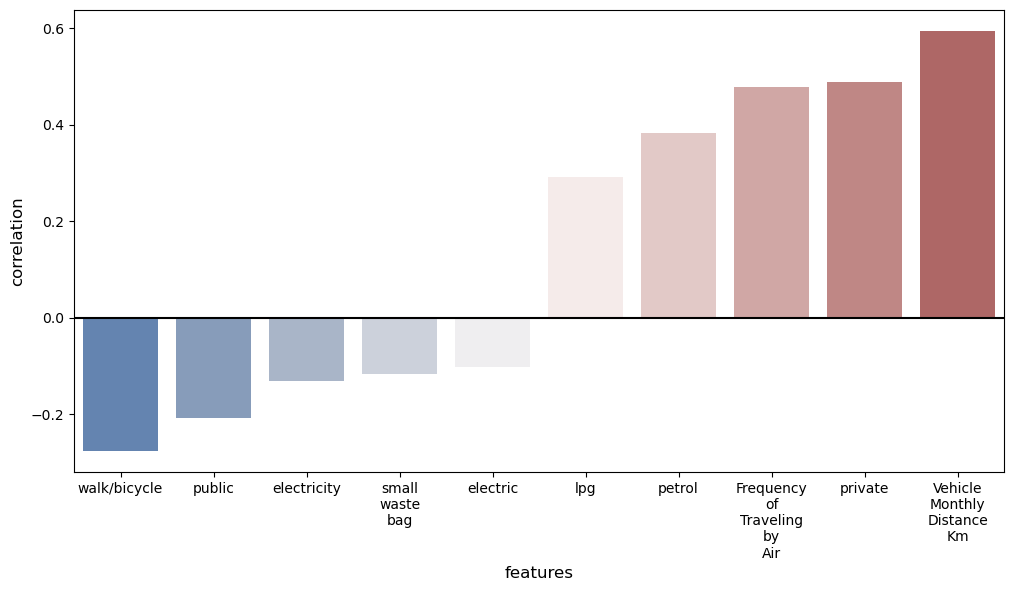

In [ ]:
# plot the top 5 least and most correlated features with carbon emissions
ce_corr = corr['CarbonEmission']
ce_corr = ce_corr.drop('CarbonEmission')
k = ce_corr.keys()
v = ce_corr.values
ce_corr_sorted = sorted(list(zip(v,k)))
ce_corr_sorted = ce_corr_sorted[:5] + ce_corr_sorted[-5:]
sigma = [t[0] for t in ce_corr_sorted]
features = [t[1] for t in ce_corr_sorted]
features = [s.replace(' ', '\n') for s in features]
correlations = pd.DataFrame({'features': features, 'correlations': sigma})
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(correlations, x='features', y='correlations', palette='vlag')
ax.set_xlabel('features', fontsize=12)
ax.set_ylabel('correlation', fontsize=12)
ax.axhline(color='black')
plt.show()

# Linear Regression

In [ ]:
# shuffle the data
dataset = np.asarray(df, dtype='int32')
np.random.seed(0)
np.random.shuffle(dataset)
# select the features
features = dataset[:,:-1]
# select the labels
labels = dataset[:,-1].reshape((len(dataset),-1))
# split into training and test sets
train_features = features[:8000]
train_labels = labels[:8000]
test_features = features[8000:]
test_labels = labels[8000:]
# fit linear regression
model = linear_model.LinearRegression()
model.fit(train_features, train_labels)
predictions = model.predict(test_features)
mae = mean_absolute_error(predictions, test_labels)
mae

368.0819415538433

[Text(0.5, 0, 'Actual Emissions'), Text(0, 0.5, 'Predicted Emissions')]

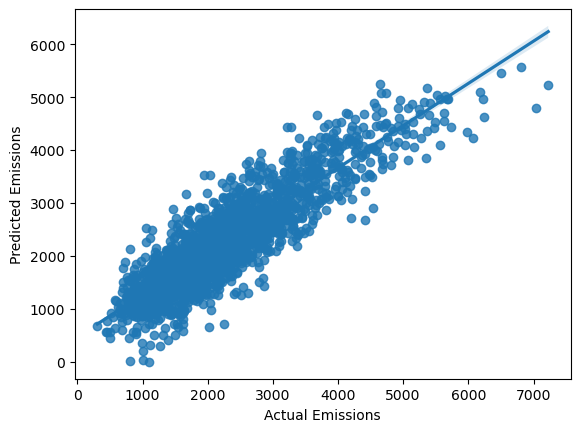

In [ ]:
# compare predictions and actual labels
ax = sns.regplot(x=test_labels, y=predictions)
ax.set(xlabel='Actual Emissions', ylabel='Predicted Emissions')

In [7]:
# encode waste bag volume 
# waste bag sizes by gallons
S = 6
M = 12
L = 18
XL = 36
volumes = [XL, L, M, S]

columns = ['extra large waste bag', 'large waste bag', 'medium waste bag', 'small waste bag']
waste_per_week = df[columns].dot(volumes) * df['Waste Bag Weekly Count']
df_waste = pd.read_csv(filepath)
df_waste = df_waste.drop(columns, axis=1)
df_waste = df_waste.drop('Waste Bag Weekly Count', axis=1) 
df_waste.insert(loc=len(df_waste.columns)-1, column='Waste Per Week', value=waste_per_week)

In [ ]:
# performance results from encoding waste volume
dataset = np.asarray(df_waste, dtype='int32')
np.random.seed(0)
np.random.shuffle(dataset)

features = dataset[:,:-1]
labels = dataset[:,-1].reshape((len(dataset),-1))

train_features = features[:8000]
train_labels = labels[:8000]
test_features = features[8000:]
test_labels = labels[8000:]

smaller_model = linear_model.Lasso()
smaller_model.fit(train_features, train_labels)
predictions = smaller_model.predict(test_features)

mae_waste = mean_absolute_error(predictions, test_labels)
mae_waste

367.4145650606538

# Feature Comparison

In [ ]:
def run_regression(df:pd.DataFrame, columns:list):
    '''
    With a given dataframe and list of features of that dataframe (the last column being the labels),
    runs a linear regression model and returns the mean absolute error of the model.
    A blank column list will default to all features.

    columns:= list of features to be used in model
    df:= pandas dataframe
    '''
    assert isinstance(df, pd.DataFrame)
    assert isinstance(columns, list)
    if len(columns) > 0:
        keys = df.keys()
        assert all(c in keys for c in columns)
        
    df_subset = df
    if len(columns) > 0:
        df_subset = df[columns]
    dataset = np.asarray(df_subset, dtype='int32')
    np.random.seed(0)
    np.random.shuffle(dataset)
    features = dataset[:,:-1]
    labels = dataset[:,-1].reshape((len(dataset),-1))
    train_features = features[:8000]
    train_labels = labels[:8000]
    test_features = features[8000:]
    test_labels = labels[8000:]
    model = linear_model.LinearRegression()
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    return mean_absolute_error(predictions, test_labels)

In [ ]:
# groups of features to plot
feature_groups = [
    ['Vehicle Monthly Distance Km', 'diesel', 'electric', 'hybrid', 'lpg', 'petrol', 'CarbonEmission'],
    ['Frequency of Traveling by Air', 'CarbonEmission'],
    ['extra large waste bag', 'large waste bag', 'medium waste bag', 'small waste bag', 'Waste Bag Weekly Count', 'CarbonEmission'],
    ['private', 'public', 'walk/bicycle', 'CarbonEmission'],
    ['coal', 'electricity', 'natural gas', 'CarbonEmission'],
    []
]
names = [
    'vehicle distance\nengine type',
    'air travel',
    'waste bag size\nwaste bag count',
    'commute method',
    'heating source',
    'combined'
]

In [11]:
# naive prediction
dataset = np.asarray(df, dtype='int32')
np.random.seed(0)
np.random.shuffle(dataset)
features = dataset[:,:-1]
labels = dataset[:,-1].reshape((len(dataset),-1))
train_features = features[:8000]
train_labels = labels[:8000]
test_features = features[8000:]
test_labels = labels[8000:]
naive_predictions = np.full(test_labels.shape, np.mean(train_labels))
mae_naive = mean_absolute_error(naive_predictions, test_labels)

In [ ]:
# grab results for all selected features groups
results = [run_regression(df, group) for group in feature_groups]
results.append(mae_naive)
names.append('training set mean')

In [ ]:
# sort for better visibility
y = results
x = names
sorted_data = list(reversed(sorted(zip(y,x))))
sorted_data

[(794.8747605000001, 'training set mean'),
 (784.0945248593476, 'heating source'),
 (780.5595, 'waste bag size\nwaste bag count'),
 (694.097375, 'commute method'),
 (656.8135570511816, 'air travel'),
 (573.8601564852956, 'vehicle distance\nengine type'),
 (368.0819415538433, 'combined')]

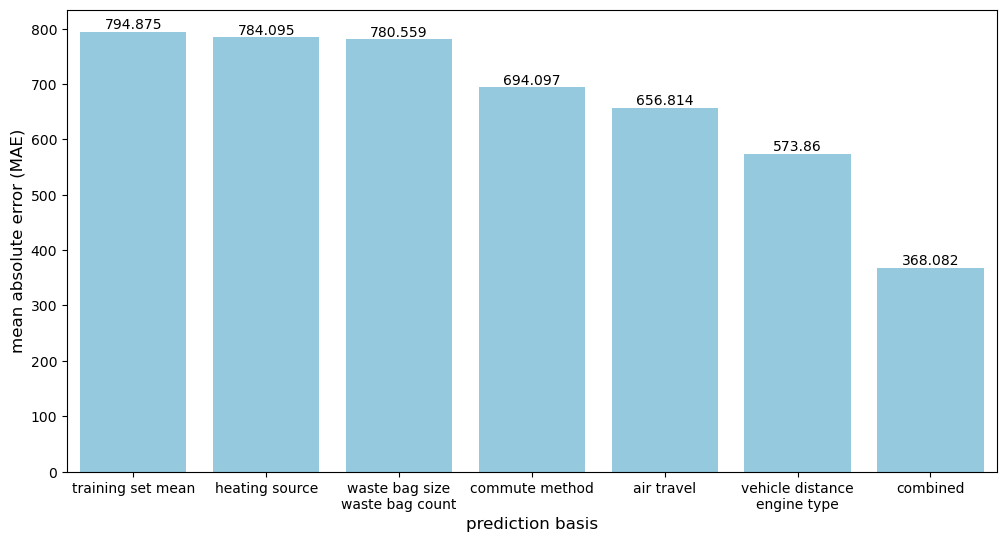

In [ ]:
# plot the model performances
y = [t[0] for t in sorted_data]
x = [t[1] for t in sorted_data]
results = pd.DataFrame({'prediction basis': x, 'mean absolute error': y})
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(results, x='prediction basis', y='mean absolute error', color='skyblue')
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_xlabel('prediction basis', fontsize=12)
ax.set_ylabel('mean absolute error (MAE)', fontsize=12)
plt.show()

# More Regression

In [15]:
# Load the data
data = pd.read_csv("./Data_extraction/extracted_data.csv")

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(data.head())

# Display basic information about the dataset
print("\nDataset information:")
print(data.info())

First 5 rows of the dataset:
   Frequency of Traveling by Air  Vehicle Monthly Distance Km  \
0                              2                          210   
1                              1                            9   
2                              0                         2472   
3                              1                           74   
4                              3                         8457   

   Waste Bag Weekly Count  CarbonEmission  Microwave  Stove  Grill  Oven  \
0                       4            2238          0      1      0     1   
1                       3            1892          1      1      0     0   
2                       1            2595          1      0      0     1   
3                       3            1074          1      0      1     0   
4                       1            4743          0      0      0     1   

   Airfryer  coal  ...  hybrid  lpg  petrol  private  public  walk/bicycle  \
0         0     1  ...       0    0       0  


Step 1: Correlation Analysis


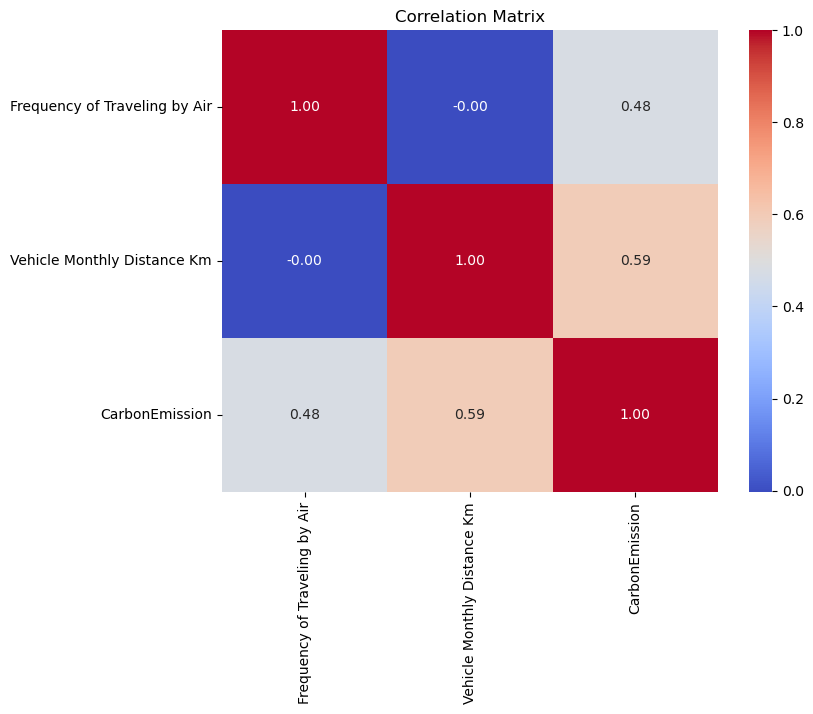

In [16]:

# Step 1: Correlation Analysis
# Analyze the correlation between air travel, vehicle distance, and carbon emissions
print("\nStep 1: Correlation Analysis")

# Calculate the correlation matrix
correlation_matrix = data[["Frequency of Traveling by Air", "Vehicle Monthly Distance Km", "CarbonEmission"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [17]:

# Step 2: Regression Analysis
# Quantify the impact of air travel and vehicle distance on carbon emissions
print("\nStep 2: Regression Analysis")

# Define features (X) and target (y)
X = data[["Frequency of Traveling by Air", "Vehicle Monthly Distance Km"]]
y = data["CarbonEmission"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Display the regression coefficients
print("Regression Coefficients:")
print("Frequency of Traveling by Air:", model.coef_[0])
print("Vehicle Monthly Distance Km:", model.coef_[1])


Step 2: Regression Analysis
Mean Squared Error: 414356.46717699413
Regression Coefficients:
Frequency of Traveling by Air: 437.05955824459875
Vehicle Monthly Distance Km: 0.2172301000699892



Step 3: Energy Consumption Comparison
Average Energy Consumption:
Air Energy Consumption        151.45000
Vehicle Energy Consumption    203.14859
dtype: float64


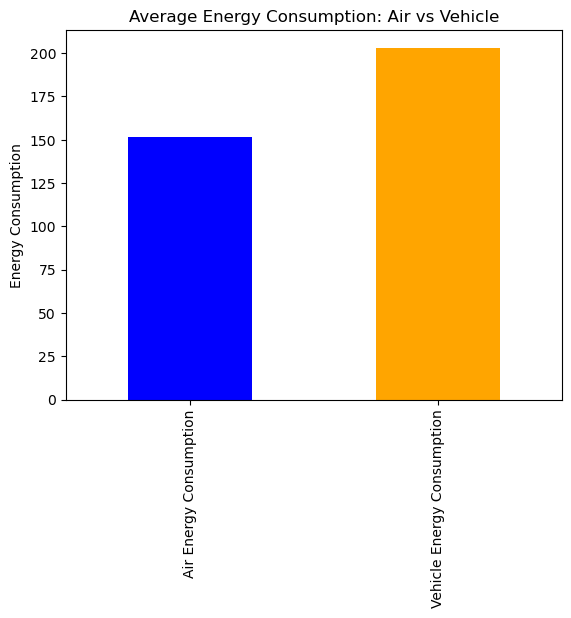

In [18]:

# Step 3: Energy Consumption Comparison
# Compare non-renewable energy consumption between air travel and vehicle distance
print("\nStep 3: Energy Consumption Comparison")

# Define energy consumption assumptions
air_energy = 100  # Energy consumed per air trip
vehicle_energy = 0.1  # Energy consumed per km by vehicle

# Calculate total energy consumption
data["Air Energy Consumption"] = data["Frequency of Traveling by Air"] * air_energy
data["Vehicle Energy Consumption"] = data["Vehicle Monthly Distance Km"] * vehicle_energy

# Compare average energy consumption
energy_comparison = data[["Air Energy Consumption", "Vehicle Energy Consumption"]].mean()
print("Average Energy Consumption:")
print(energy_comparison)

# Visualize energy consumption comparison
energy_comparison.plot(kind="bar", color=["blue", "orange"])
plt.title("Average Energy Consumption: Air vs Vehicle")
plt.ylabel("Energy Consumption")
plt.show()

In [19]:

# Step 4: Plastic Bag Usage Analysis
# Analyze the relationship between plastic bag usage and carbon emissions
print("\nStep 4: Plastic Bag Usage Analysis")

# Calculate the correlation between plastic bag usage and carbon emissions
plastic_correlation = data["Waste Bag Weekly Count"].corr(data["CarbonEmission"])
print(f"Correlation between Waste Bag Weekly Count and CarbonEmission: {plastic_correlation}")

# Perform regression analysis
X_plastic = data[["Waste Bag Weekly Count"]]
y_plastic = data["CarbonEmission"]

# Split the data into training and testing sets
X_train_plastic, X_test_plastic, y_train_plastic, y_test_plastic = train_test_split(X_plastic, y_plastic, test_size=0.2, random_state=42)

# Train a linear regression model
model_plastic = linear_model.LinearRegression()
model_plastic.fit(X_train_plastic, y_train_plastic)

# Make predictions
y_pred_plastic = model_plastic.predict(X_test_plastic)

# Evaluate the model
mse_plastic = mean_squared_error(y_test_plastic, y_pred_plastic)
print(f"Mean Squared Error (Plastic): {mse_plastic}")

# Display the regression coefficient
print("Regression Coefficient (Plastic):", model_plastic.coef_[0])


Step 4: Plastic Bag Usage Analysis
Correlation between Waste Bag Weekly Count and CarbonEmission: 0.15919337168893968
Mean Squared Error (Plastic): 1010513.0484261117
Regression Coefficient (Plastic): 80.22961467252381



Step 5: Visualization Summary


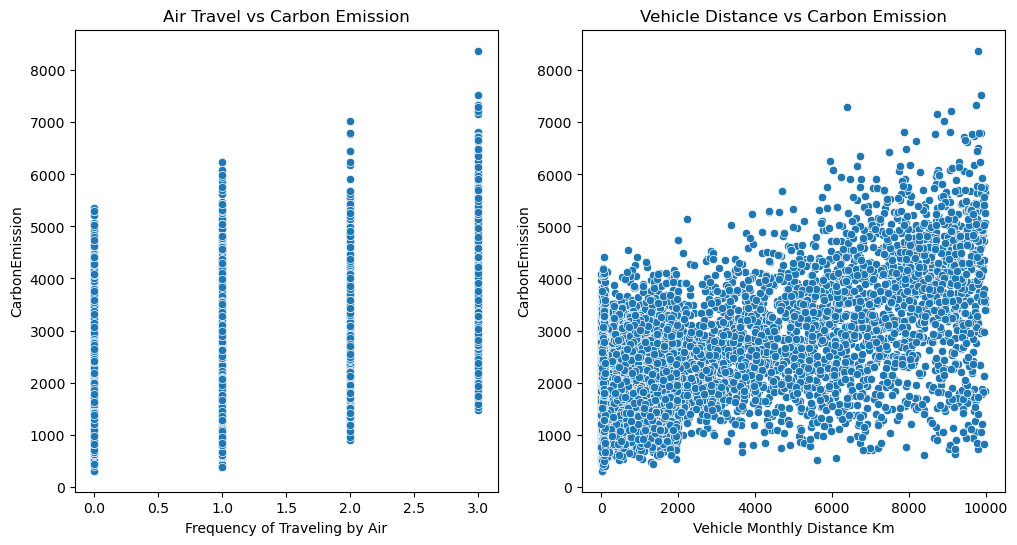

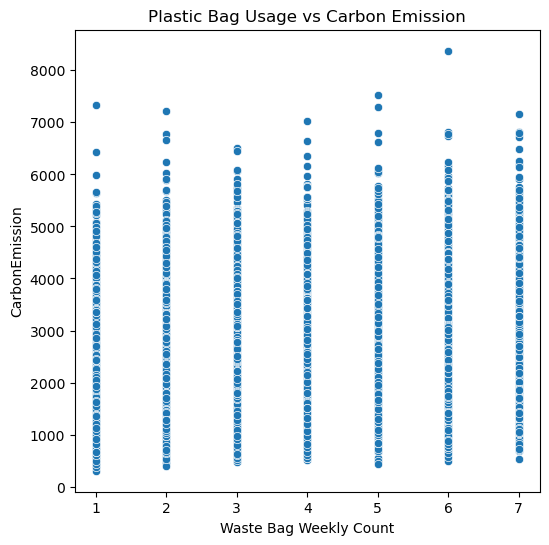


Conclusion:
1. Air travel and vehicle distance have a significant impact on carbon emissions.
2. Air travel consumes more non-renewable energy compared to vehicle distance.
3. Plastic bag usage has a moderate impact on carbon emissions.


In [20]:

# Step 5: Visualization Summary
# Visualize the relationships between air travel, vehicle distance, plastic bag usage, and carbon emissions
print("\nStep 5: Visualization Summary")

# Air travel vs carbon emissions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x="Frequency of Traveling by Air", y="CarbonEmission", data=data)
plt.title("Air Travel vs Carbon Emission")

# Vehicle distance vs carbon emissions
plt.subplot(1, 2, 2)
sns.scatterplot(x="Vehicle Monthly Distance Km", y="CarbonEmission", data=data)
plt.title("Vehicle Distance vs Carbon Emission")
plt.show()

# Plastic bag usage vs carbon emissions
plt.figure(figsize=(6, 6))
sns.scatterplot(x="Waste Bag Weekly Count", y="CarbonEmission", data=data)
plt.title("Plastic Bag Usage vs Carbon Emission")
plt.show()

# Conclusion
print("\nConclusion:")
print("1. Air travel and vehicle distance have a significant impact on carbon emissions.")
print("2. Air travel consumes more non-renewable energy compared to vehicle distance.")
print("3. Plastic bag usage has a moderate impact on carbon emissions.")

# Clustering

In [2]:
# Load and preprocess data
df = pd.read_csv('./Data_extraction/extracted_data.csv')
numerical_cols = ['Frequency of Traveling by Air', 'Vehicle Monthly Distance Km', 'CarbonEmission']
binary_cols = [col for col in df.columns if col not in numerical_cols]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])

# Combine scaled numerical and binary features for clustering
X = np.hstack([X_scaled, df[binary_cols].values])


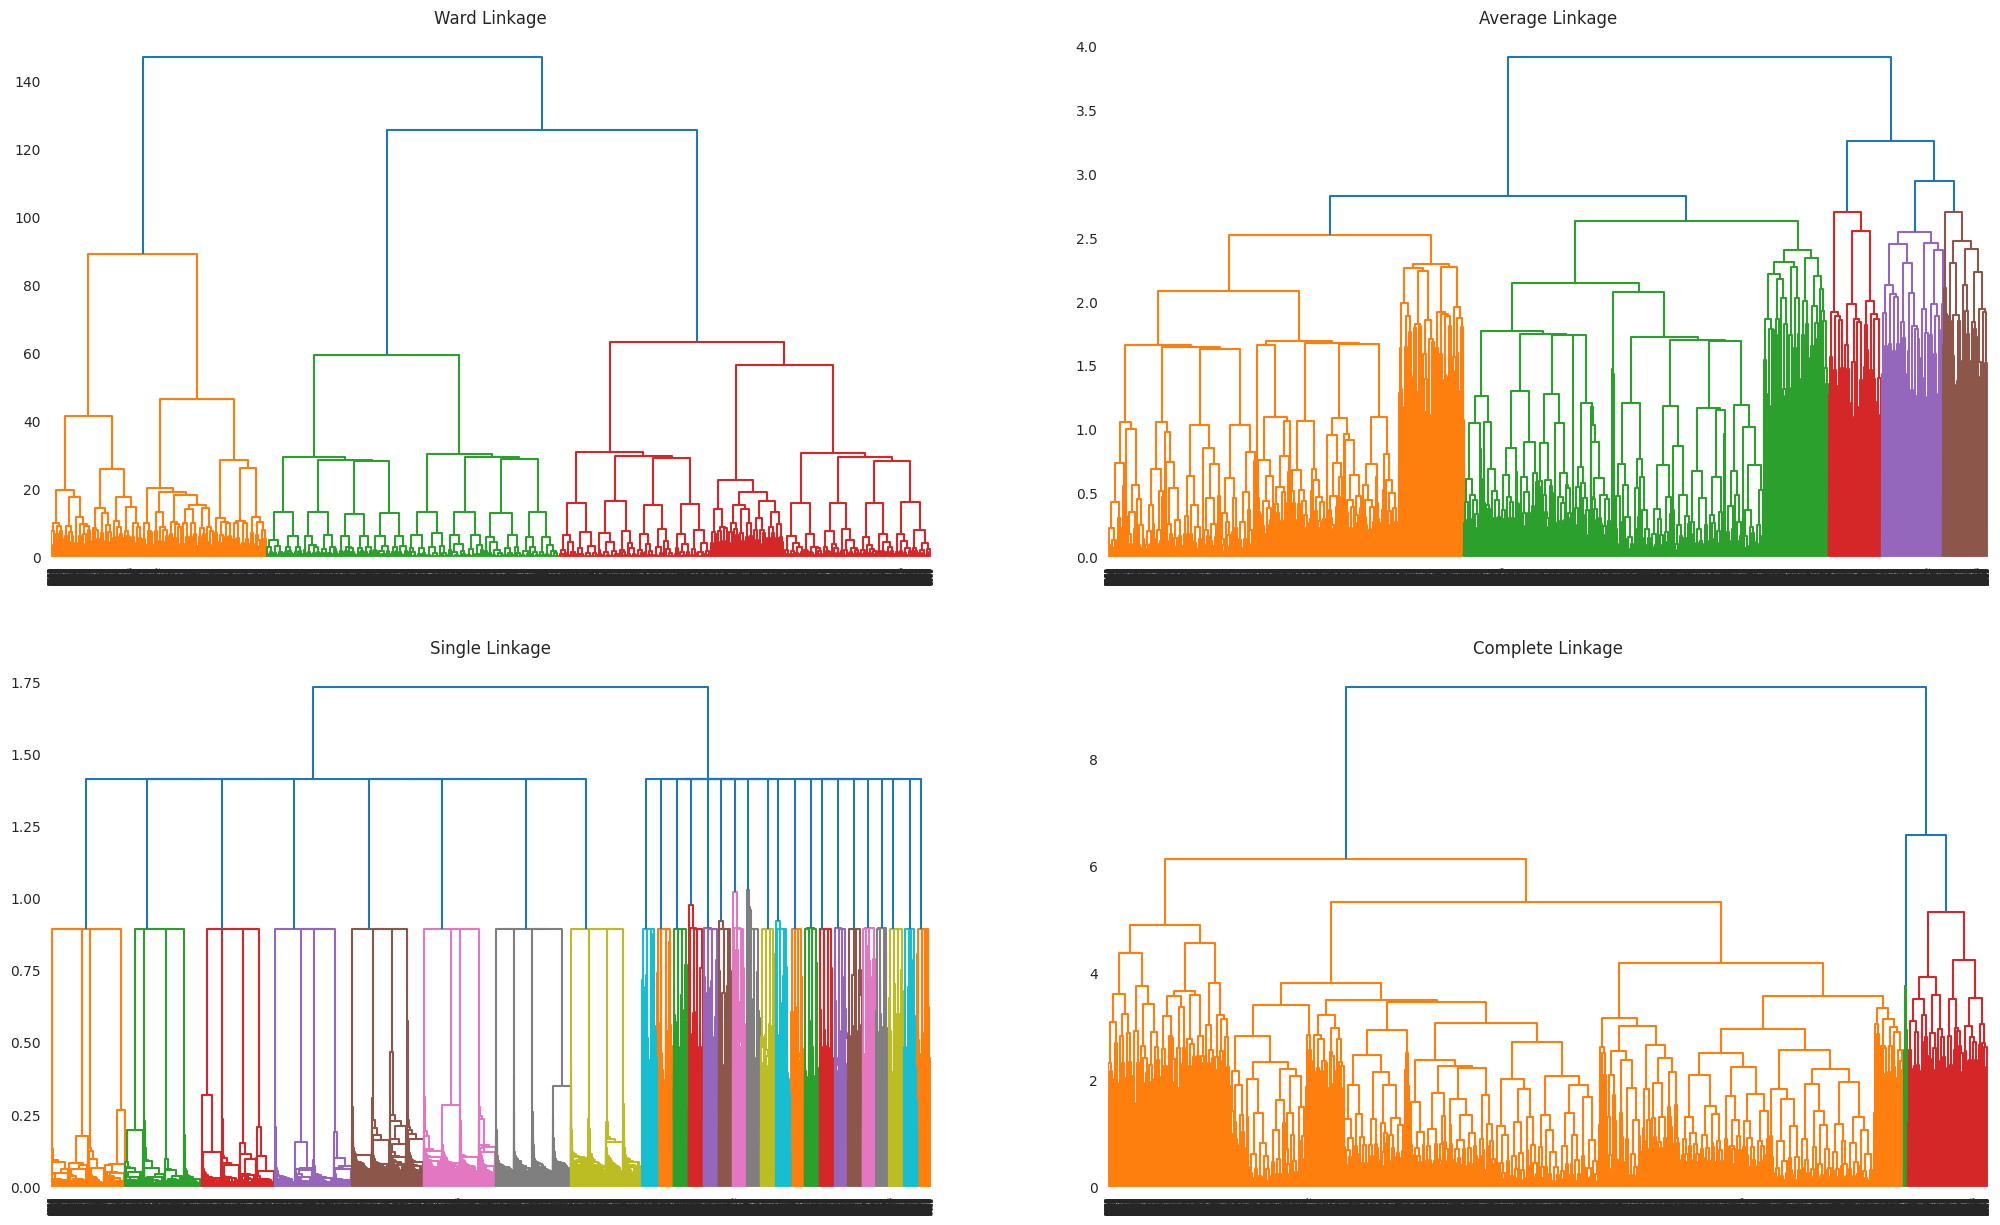

In [3]:
# Plot 4 kinds of hierarchical clustering dendrograms
plt.figure(figsize=(25, 15))

plt.subplot(221)
plt.title('Ward Linkage')
Z_ward = linkage(X, 'ward')
dendrogram(Z_ward, labels=df.index)
plt.savefig(".Notebooks/ward.svg", dpi=600, format="svg")

plt.subplot(222)
plt.title('Average Linkage')
Z_average = linkage(X, 'average')
dendrogram(Z_average, labels=df.index)
plt.savefig(".Notebooks/average.svg", dpi=600, format="svg")

plt.subplot(223)
plt.title('Single Linkage')
Z_single = linkage(X, 'single')
dendrogram(Z_single, labels=df.index)
plt.savefig(".Notebooks/single.svg", dpi=600, format="svg")

plt.subplot(224)
plt.title('Complete Linkage')
Z_complete = linkage(X, 'complete')
dendrogram(Z_complete, labels=df.index)
plt.savefig(".Notebooks/complete.svg", dpi=600, format="svg")
plt.show()


In [4]:
# Agglomerative Clustering with Ward linkage
agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')  # Reduced to 3 for simplicity
df['Cluster'] = agg.fit_predict(X)


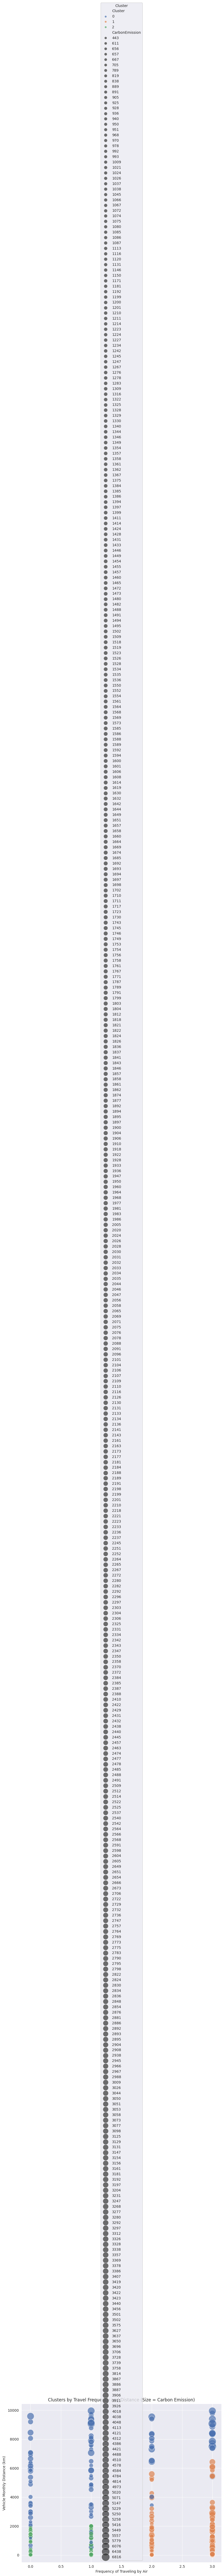

In [5]:
# 1. Random Sampling to Reduce Data Overlap (500 random samples)
sample_df = df.sample(n=500, random_state=42)

# 2. Plot the Clusters with Transparency (Alpha)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=sample_df['Frequency of Traveling by Air'],
    y=sample_df['Vehicle Monthly Distance Km'],
    hue=sample_df['Cluster'],
    size=sample_df['CarbonEmission'],
    palette='deep',
    sizes=(50, 500),
    legend='full',
    alpha=0.7  # Set transparency to avoid overlapping points
)
plt.title('Clusters by Travel Frequency and Distance (Size = Carbon Emission)')
plt.xlabel('Frequency of Traveling by Air')
plt.ylabel('Vehicle Monthly Distance (km)')
plt.legend(title='Cluster')
plt.show()


In [7]:
# Cluster assignments using distance criterion
F_single = fcluster(Z_single, 3.2, criterion='distance')
F_complete = fcluster(Z_complete, 6, criterion='distance')
df['Single_Cluster'] = F_single
df['Complete_Cluster'] = F_complete


In [8]:
# Mean of features per Complete linkage cluster
dfc = pd.DataFrame()
for i in range(1, max(F_complete) + 1):
    cluster_mean = df[df['Complete_Cluster'] == i].mean()
    dfc[i] = cluster_mean[numerical_cols + binary_cols]
dfc = dfc.sort_values(by='CarbonEmission', axis=1)
print("Mean Features per Complete Linkage Cluster:")
print(dfc)


Mean Features per Complete Linkage Cluster:
                                         2            1            4  \
Frequency of Traveling by Air     1.504120     1.040598     2.273128   
Vehicle Monthly Distance Km     664.467888  6300.717236  6618.994493   
CarbonEmission                 1945.779725  2614.707265  4262.801762   
coal                              0.244735     0.282051     0.272026   
electricity                       0.258600     0.248575     0.237885   
natural gas                       0.252714     0.230769     0.209251   
wood                              0.243950     0.238604     0.280837   
diesel                            0.022106     0.186610     0.210352   
electric                          0.027861     0.323362     0.004405   
hybrid                            0.023676     0.226496     0.157489   
lpg                               0.023806     0.183761     0.263216   
petrol                            0.023414     0.079772     0.364537   
private             

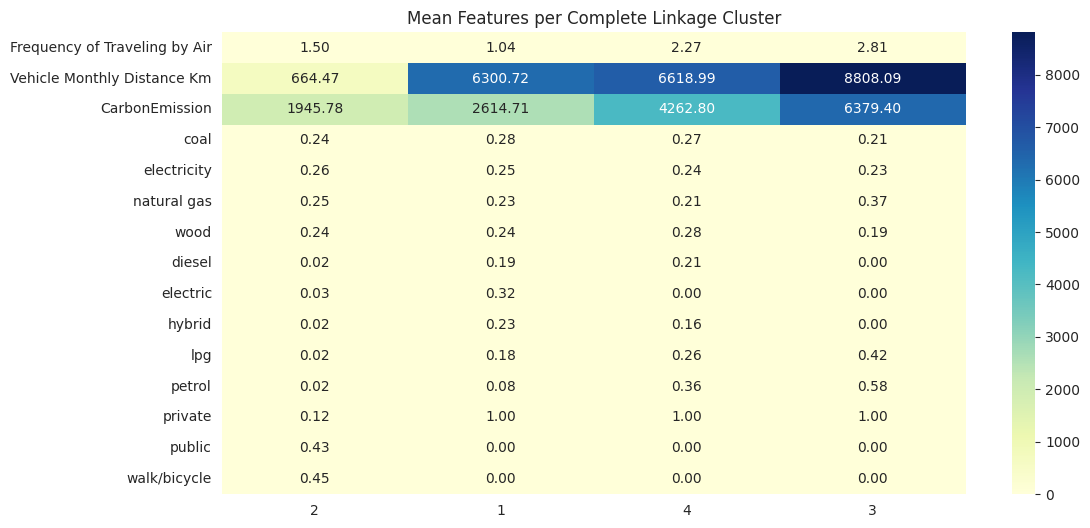

In [9]:
# Seaborn Heatmap of cluster means
plt.figure(figsize=(12, 6))
sns.heatmap(dfc, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mean Features per Complete Linkage Cluster')
plt.show()


In [ ]:
# Load and preprocess data
df = pd.read_csv('../Data_extraction/extracted_data.csv')
numerical_cols = ['Frequency of Traveling by Air', 'Vehicle Monthly Distance Km', 'CarbonEmission']
binary_cols = [col for col in df.columns if col not in numerical_cols]

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])

# Combine scaled numerical and binary features for clustering
X = np.hstack([X_scaled, df[binary_cols].values])


# Plot 4 kinds of hierarchical clustering dendrograms
plt.figure(figsize=(25, 15))

plt.subplot(221)
plt.title('Ward Linkage')
Z_ward = linkage(X, 'ward')
dendrogram(Z_ward, labels=df.index)
plt.savefig(".Notebooks/ward.svg", dpi=600, format="svg")

plt.subplot(222)
plt.title('Average Linkage')
Z_average = linkage(X, 'average')
dendrogram(Z_average, labels=df.index)
plt.savefig(".Notebooks/average.svg", dpi=600, format="svg")

plt.subplot(223)
plt.title('Single Linkage')
Z_single = linkage(X, 'single')
dendrogram(Z_single, labels=df.index)
plt.savefig(".Notebooks/single.svg", dpi=600, format="svg")

plt.subplot(224)
plt.title('Complete Linkage')
Z_complete = linkage(X, 'complete')
dendrogram(Z_complete, labels=df.index)
plt.savefig(".Notebooks/complete.svg", dpi=600, format="svg")
plt.show()


# Agglomerative Clustering with Ward linkage
agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')  # Reduced to 3 for simplicity
df['Cluster'] = agg.fit_predict(X)


# 1. Random Sampling to Reduce Data Overlap (500 random samples)
sample_df = df.sample(n=500, random_state=42)

# 2. Plot the Clusters with Transparency (Alpha)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=sample_df['Frequency of Traveling by Air'],
    y=sample_df['Vehicle Monthly Distance Km'],
    hue=sample_df['Cluster'],
    size=sample_df['CarbonEmission'],
    palette='deep',
    sizes=(50, 500),
    legend='full',
    alpha=0.7  # Set transparency to avoid overlapping points
)
plt.title('Clusters by Travel Frequency and Distance (Size = Carbon Emission)')
plt.xlabel('Frequency of Traveling by Air')
plt.ylabel('Vehicle Monthly Distance (km)')
plt.legend(title='Cluster')
plt.show()


# 3. PCA Dimensionality Reduction for Better Visualization
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # Use the features that were clustered

# Scatter plot with PCA reduction
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['Cluster'],
    size=df['CarbonEmission'],
    palette='deep',
    sizes=(50, 500),
    legend='full',
    alpha=0.7  # Set transparency to avoid overlapping points
)
plt.title('PCA-based Clusters (Size = Carbon Emission)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


# Cluster assignments using distance criterion
F_single = fcluster(Z_single, 3.2, criterion='distance')
F_complete = fcluster(Z_complete, 6, criterion='distance')
df['Single_Cluster'] = F_single
df['Complete_Cluster'] = F_complete


# Mean of features per Complete linkage cluster
dfc = pd.DataFrame()
for i in range(1, max(F_complete) + 1):
    cluster_mean = df[df['Complete_Cluster'] == i].mean()
    dfc[i] = cluster_mean[numerical_cols + binary_cols]
dfc = dfc.sort_values(by='CarbonEmission', axis=1)
print("Mean Features per Complete Linkage Cluster:")
print(dfc)


# Seaborn Heatmap of cluster means
plt.figure(figsize=(12, 6))
sns.heatmap(dfc, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Mean Features per Complete Linkage Cluster')
plt.show()


# Recommendations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Visulaizing the information present in a row from the original dataset
df = pd.read_csv('../Data_extraction/CarbonEmission.csv')
pd.set_option('display.max_columns', None)
df.head(3)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595


In [3]:
#Visualizing the information present in a row from the extracted dataset
df = pd.read_csv('../Data_extraction/extracted_data_v1.csv')

# change display settings to show all columns
pd.set_option('display.max_columns', None)

df.head(3)

,coal,electricity,natural gas,wood,private,public,walk/bicycle,diesel,electric,hybrid,lpg,petrol,Vehicle Monthly Distance Km,Frequency of Traveling by Air,extra large waste bag,large waste bag,medium waste bag,small waste bag,Waste Bag Weekly Count,CarbonEmission
0,1,0,0,0,0,1,0,0,0,0,0,0,210,2,0,1,0,0,4,2238
1,0,0,1,0,0,0,1,0,0,0,0,0,9,1,1,0,0,0,3,1892
2,0,0,0,1,1,0,0,0,0,0,0,1,2472,0,0,0,0,1,1,2595


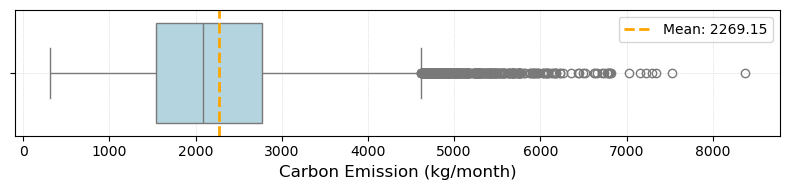

In [4]:
#Calculating and visualizing the mean Carbon Emissions from the dataset
plt.figure(figsize=(8, 2))  
sns.boxplot(data=df, x="CarbonEmission",color='lightblue')
mean = df['CarbonEmission'].mean()
#max = df['CarbonEmission'].max()
#print(max)

# add mean as orange line
plt.axvline(df['CarbonEmission'].mean(), color='orange', linestyle='--', label=f'Mean: {mean:.2f}', linewidth=2)

# Design adjustments
plt.xlabel('Carbon Emission (kg/month)', fontsize=12)
plt.legend(loc='upper right')  

plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)  # Add Light grid

plt.tight_layout()
plt.show()

In [5]:
# calculate Median 
median_CE = df['CarbonEmission'].median()  
print(median_CE)

# create new column
df['lower_half_median'] = df['CarbonEmission'] <= median_CE



2080.0


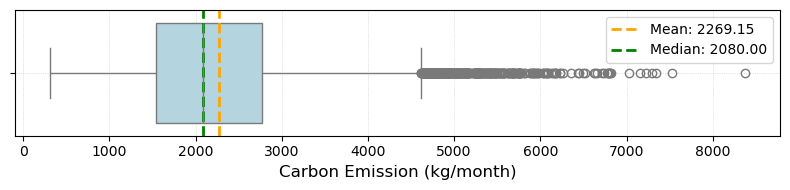

In [6]:
#Plotting the mean and median of the dataset
plt.figure(figsize=(8, 2))  
sns.boxplot(data=df, x="CarbonEmission",color='lightblue')
mean = df['CarbonEmission'].mean()

# add mean as orange line
plt.axvline(df['CarbonEmission'].mean(), color='orange', linestyle='--', label=f'Mean: {mean:.2f}', linewidth=2)

# add mean as orange line
plt.axvline(df['CarbonEmission'].median(), color='green', linestyle='--', label=f'Median: {median_CE:.2f}', linewidth=2)

# Design adjustments
plt.xlabel('Carbon Emission (kg/month)', fontsize=12)
plt.legend(loc='upper right')  

plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.7)  # Add Light grid

plt.tight_layout()
plt.show()

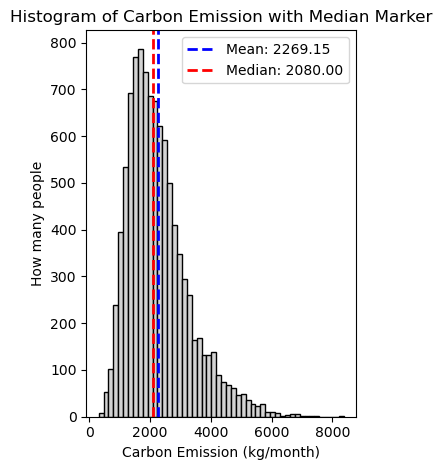

In [7]:
#Visualize the mean and median using a Histogram
# Create Histogram
plt.subplot(1, 2, 2)  # Histogram
plt.hist(df['CarbonEmission'], bins=50, color='lightgray', edgecolor='black')
# add mean as blue line
plt.axvline(df['CarbonEmission'].mean(), color='blue', linestyle='--', label=f'Mean: {mean:.2f}', linewidth=2)
# add median as red line
plt.axvline(median_CE, color='red', linestyle='dashed', label=f'Median: {median_CE:.2f}', linewidth=2)  # Line for the median
plt.legend(loc='upper right') 
plt.title('Histogram of Carbon Emission with Median Marker')
plt.xlabel('Carbon Emission (kg/month)')
plt.ylabel('How many people')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [8]:
# Select one random row for which the recommendations will be made
#random_row = df.sample(n=1)

# Specify the row index you want to pick (e.g., row at index 5)
row_index = 4  # Change this to the desired row index

# Select the row using .iloc[] (index-based selection)
selected_row = df.iloc[row_index]
individual = selected_row['CarbonEmission']

# Display the random row
print(selected_row)
print(type(selected_row))
print(selected_row['CarbonEmission'])

coal                                 1
electricity                          0
natural gas                          0
wood                                 0
private                              1
public                               0
walk/bicycle                         0
diesel                               1
electric                             0
hybrid                               0
lpg                                  0
petrol                               0
Vehicle Monthly Distance Km       8457
Frequency of Traveling by Air        3
extra large waste bag                0
large waste bag                      1
medium waste bag                     0
small waste bag                      0
Waste Bag Weekly Count               1
CarbonEmission                    4743
lower_half_median                False
Name: 4, dtype: object
<class 'pandas.core.series.Series'>
4743


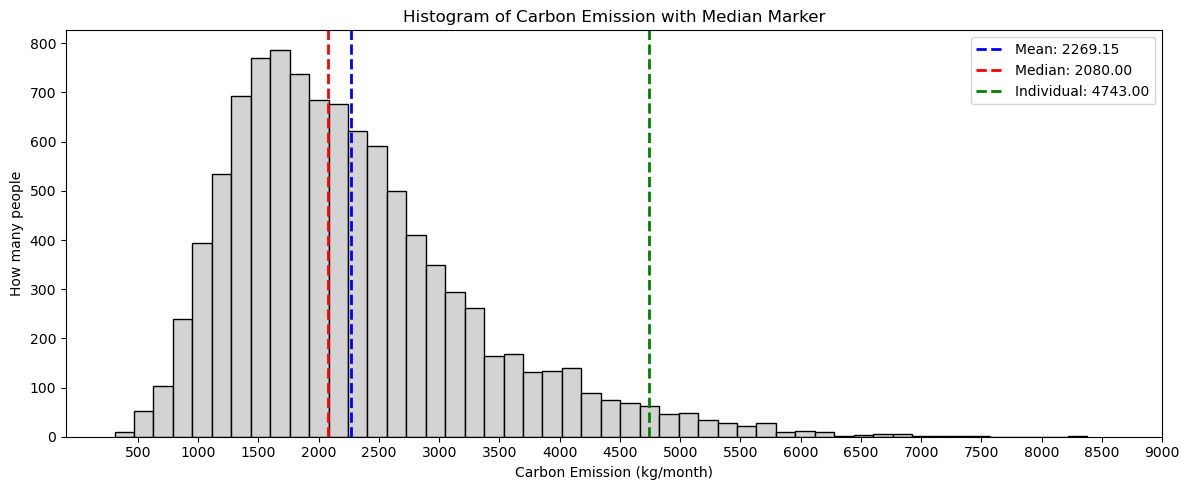

In [9]:
#Visualize the Carbon Emissions of the chosen individual relative to the mean and median of the dataset
# Create Histogram
#plt.subplot(1, 2, 2)  # Histogram
plt.figure(figsize=(12, 5))
plt.hist(df['CarbonEmission'], bins=50, color='lightgray', edgecolor='black')
# add mean as blue line
plt.axvline(df['CarbonEmission'].mean(), color='blue', linestyle='--', label=f'Mean: {mean:.2f}', linewidth=2)
# add median as red line 
plt.axvline(median_CE, color='red', linestyle='dashed', label=f'Median: {median_CE:.2f}', linewidth=2)  # Line for the median
# add the individuals' carbon emission as green line
plt.axvline(selected_row['CarbonEmission'], color='green', linestyle='dashed', label=f'Individual: {individual:.2f}', linewidth=2)  # Line for the individual
plt.legend(loc='upper right') 
plt.title('Histogram of Carbon Emission with Median Marker')
plt.xlabel('Carbon Emission (kg/month)')
plt.ylabel('How many people')
plt.xticks(range(500, 9001, 500))  # Set tick positions every 10 units

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

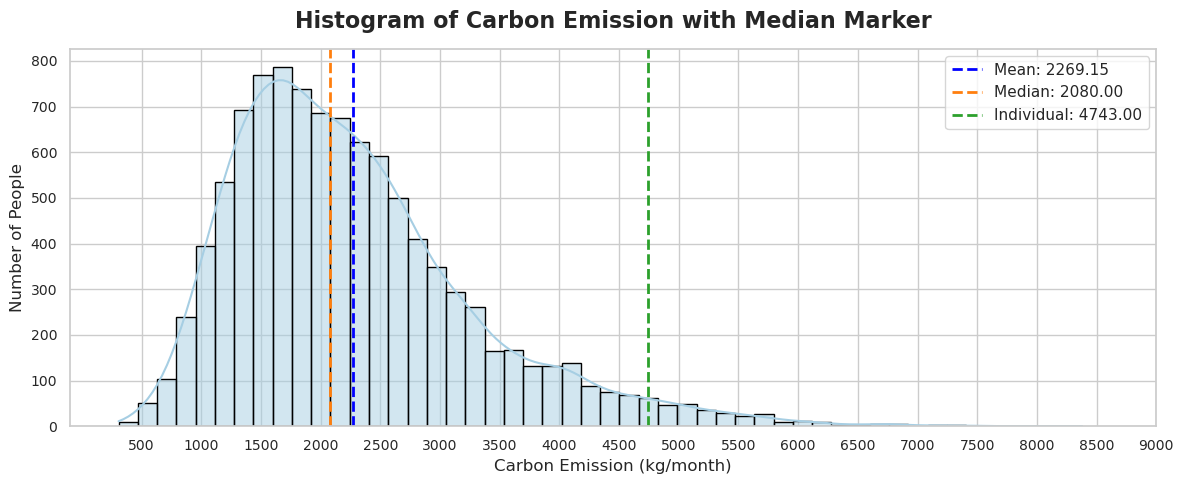

In [10]:
# another visualization approach for the above plot
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")  # Clean background style

# Histogram with kernel density estimate (KDE) for smoother visualization
sns.histplot(df['CarbonEmission'], bins=50, color='#A6CEE3', edgecolor='black', kde=True)

# Add vertical lines for mean, median, and individual value with cleaner styling
#plt.axvline(df['CarbonEmission'].mean(), color='#1F77B4', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(df['CarbonEmission'].mean(), color='blue', linestyle='--', label=f'Mean: {mean:.2f}', linewidth=2)
plt.axvline(median_CE, color='#FF7F0E', linestyle='--', linewidth=2, label=f'Median: {median_CE:.2f}')
plt.axvline(selected_row['CarbonEmission'], color='#2CA02C', linestyle='--', linewidth=2, label=f'Individual: {individual:.2f}')

# Add legend with a frame for better visibility
plt.legend(loc='upper right', frameon=True)

# Improve title and axis labels aesthetics
plt.title('Histogram of Carbon Emission with Median Marker', fontsize=16, weight='bold', pad=15)
plt.xlabel('Carbon Emission (kg/month)', fontsize=12)
plt.ylabel('Number of People', fontsize=12)

# Adjust ticks and grid style
plt.xticks(range(500, 9001, 500), fontsize=10)
plt.yticks(fontsize=10)

# Final adjustments
plt.tight_layout()
plt.show()

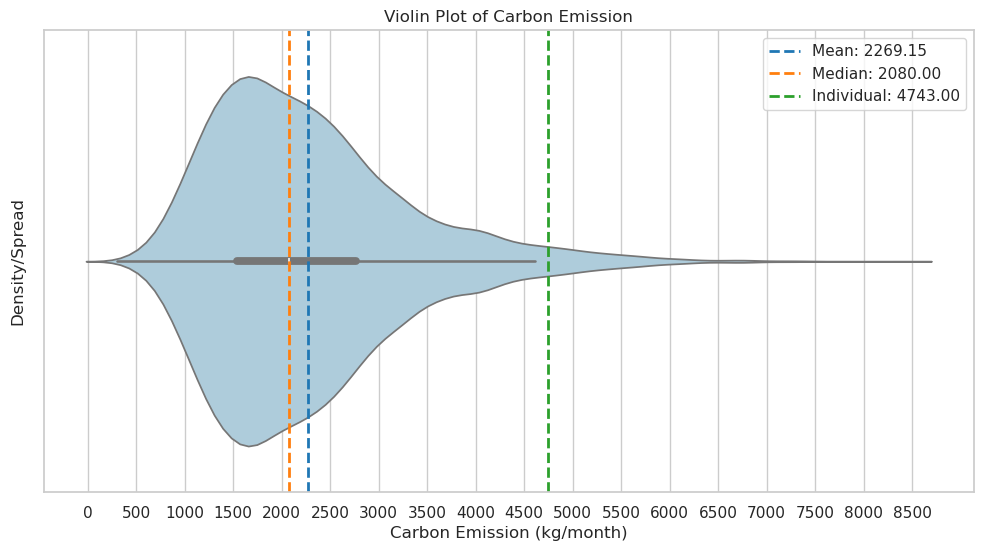

In [11]:
# Violin plot approach for the above plot : Gives both the density and spread across the dataset 
plt.figure(figsize=(12, 6))
sns.violinplot(x=df['CarbonEmission'], color='#A6CEE3')

# Add vertical lines for mean, median, and individual value
plt.axvline(df['CarbonEmission'].mean(), color='#1F77B4', linestyle='--', linewidth=2, label=f'Mean: {mean:.2f}')
plt.axvline(median_CE, color='#FF7F0E', linestyle='--', linewidth=2, label=f'Median: {median_CE:.2f}')
plt.axvline(selected_row['CarbonEmission'], color='#2CA02C', linestyle='--', linewidth=2, label=f'Individual: {individual:.2f}')

# Set x-axis ticks every 500 units
plt.xticks(range(0, int(df['CarbonEmission'].max()) + 500, 500))
plt.ylabel('Density/Spread')

plt.legend(loc='upper right')
plt.title('Violin Plot of Carbon Emission')
plt.xlabel('Carbon Emission (kg/month)')
plt.show()

In [12]:
# Populate the parameters corresponding to each feature column in the dataset as calculated via the linear regression approach during the analysis portion
parameters = []
parameters = [(209.32695337036634, 'coal'),
 (226.18317503997898, 'electricity'),
 (7.669612228566583, 'natural gas'),
 (9.186609440980124, 'wood'),
 (59.33974944199982, 'private'),
 (87.59701334569431, 'public'),
 (28.257263903694355, 'walk/bicycle'),
 (203.82392805700292, 'diesel'),
 (1052.3751464029094, 'electric'),
 (226.6928482873863, 'hybrid'),
 (333.856348384034, 'lpg'),
 (800.7274676912599, 'petrol'),
 (0.20770529391801346, 'Vehicle Monthly Distance Km'),
 (440.8459170141105, 'Frequency of Traveling by Air'),
 (202.35218608701445, 'extra large waste bag'),
 (63.792123296977955, 'large waste bag'),
 (69.14157052281868, 'medium waste bag'),
 (79.22862176805614, 'Waste Bag Weekly Count'),
 (197.0027388611744, 'small waste bag')]
print(parameters)
print(len(parameters))

[(209.32695337036634, 'coal'), (226.18317503997898, 'electricity'), (7.669612228566583, 'natural gas'), (9.186609440980124, 'wood'), (59.33974944199982, 'private'), (87.59701334569431, 'public'), (28.257263903694355, 'walk/bicycle'), (203.82392805700292, 'diesel'), (1052.3751464029094, 'electric'), (226.6928482873863, 'hybrid'), (333.856348384034, 'lpg'), (800.7274676912599, 'petrol'), (0.20770529391801346, 'Vehicle Monthly Distance Km'), (440.8459170141105, 'Frequency of Traveling by Air'), (202.35218608701445, 'extra large waste bag'), (63.792123296977955, 'large waste bag'), (69.14157052281868, 'medium waste bag'), (79.22862176805614, 'Waste Bag Weekly Count'), (197.0027388611744, 'small waste bag')]
19


In [13]:
# Divide the above paramters into distinct groups : Required for the recommendation model to suggest new choices
heat_source = parameters[:4]
print(heat_source)
# Get the coloumn lable values out : Required data structuring to align with the recommendation model usage
heat_source = [value for _,value in heat_source]
print(heat_source)

[(209.32695337036634, 'coal'), (226.18317503997898, 'electricity'), (7.669612228566583, 'natural gas'), (9.186609440980124, 'wood')]
['coal', 'electricity', 'natural gas', 'wood']


In [14]:
# Divide the above paramters into distinct groups : Required for the recommendation model to suggest new choices
mode_transport = parameters[4:6]
print(mode_transport)
# Get the coloumn lable values out : Required data structuring to align with the recommendation model usage
mode_transport = [value for _,value in mode_transport]
print(mode_transport)

[(59.33974944199982, 'private'), (87.59701334569431, 'public')]
['private', 'public']


In [15]:
# Divide the above paramters into distinct groups : Required for the recommendation model to suggest new choices
vehicle_type = parameters[6:12]
print(vehicle_type)
# Get the coloumn lable values out : Required data structuring to align with the recommendation model usage
vehicle_type = [value for _,value in vehicle_type]
print(vehicle_type)

[(28.257263903694355, 'walk/bicycle'), (203.82392805700292, 'diesel'), (1052.3751464029094, 'electric'), (226.6928482873863, 'hybrid'), (333.856348384034, 'lpg'), (800.7274676912599, 'petrol')]
['walk/bicycle', 'diesel', 'electric', 'hybrid', 'lpg', 'petrol']


In [16]:
# Divide the above paramters into distinct groups : Required format for the recommendation model to suggest new choices
vehicle_distance = parameters[12][1]
print(vehicle_distance)

Vehicle Monthly Distance Km


In [17]:
# Divide the above paramters into distinct groups : Required format for the recommendation model to suggest new choices
air_travel_freq = parameters[13][1]
print(air_travel_freq)

Frequency of Traveling by Air


In [18]:
# Divide the above paramters into distinct groups : Required for the recommendation model to suggest new choices
waste_bag = []
for item in parameters:
    if (item[1] == 'Waste Bag Weekly Count' or 'waste' in item[1]):
        waste_bag.append(item)

print(waste_bag)
# Get the coloumn lable values out : Required data structuring to align with the recommendation model usage
waste_bag = [value for _,value in waste_bag]
print(waste_bag)

[(202.35218608701445, 'extra large waste bag'), (63.792123296977955, 'large waste bag'), (69.14157052281868, 'medium waste bag'), (79.22862176805614, 'Waste Bag Weekly Count'), (197.0027388611744, 'small waste bag')]
['extra large waste bag', 'large waste bag', 'medium waste bag', 'Waste Bag Weekly Count', 'small waste bag']


In [19]:
print(selected_row)

coal                                 1
electricity                          0
natural gas                          0
wood                                 0
private                              1
public                               0
walk/bicycle                         0
diesel                               1
electric                             0
hybrid                               0
lpg                                  0
petrol                               0
Vehicle Monthly Distance Km       8457
Frequency of Traveling by Air        3
extra large waste bag                0
large waste bag                      1
medium waste bag                     0
small waste bag                      0
Waste Bag Weekly Count               1
CarbonEmission                    4743
lower_half_median                False
Name: 4, dtype: object


In [20]:
#type(selected_row)
print(selected_row.index[19])
print(list(selected_row))
len(list(selected_row))
#print(selected_row)

CarbonEmission
[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 8457, 3, 0, 1, 0, 0, 1, 4743, False]


21

In [21]:
# Update the slected row to have only the relevant choices for an individual
selected_row_update = selected_row.iloc[:-1]
print(selected_row_update)
#print(len(list(selected_row_update)))
#print(len(parameters))

# We align the format and sequence of feature columns in the extracted paramtwers from the linear regression matches with the sequence of feature columns in the slected row
parameters_checked = [None] * len(parameters)
for i in range(len(parameters)):
    #print(i)
    for j in range(len(list(selected_row_update))):
        #print(j)
        if(parameters[i][1]) == selected_row.index[j]:
            #parameters_checked.append(parameters[i])
            parameters_checked[j] = parameters[i]
            
print(parameters)
print(parameters_checked)
print(selected_row.loc['CarbonEmission'])

# We update the updated selected row into a dictionary : Required data format for the recommendation model
row = selected_row_update.to_dict()

coal                                1
electricity                         0
natural gas                         0
wood                                0
private                             1
public                              0
walk/bicycle                        0
diesel                              1
electric                            0
hybrid                              0
lpg                                 0
petrol                              0
Vehicle Monthly Distance Km      8457
Frequency of Traveling by Air       3
extra large waste bag               0
large waste bag                     1
medium waste bag                    0
small waste bag                     0
Waste Bag Weekly Count              1
CarbonEmission                   4743
Name: 4, dtype: object
[(209.32695337036634, 'coal'), (226.18317503997898, 'electricity'), (7.669612228566583, 'natural gas'), (9.186609440980124, 'wood'), (59.33974944199982, 'private'), (87.59701334569431, 'public'), (28.257263903694355, 

In [22]:
print(row)

{'coal': 1, 'electricity': 0, 'natural gas': 0, 'wood': 0, 'private': 1, 'public': 0, 'walk/bicycle': 0, 'diesel': 1, 'electric': 0, 'hybrid': 0, 'lpg': 0, 'petrol': 0, 'Vehicle Monthly Distance Km': 8457, 'Frequency of Traveling by Air': 3, 'extra large waste bag': 0, 'large waste bag': 1, 'medium waste bag': 0, 'small waste bag': 0, 'Waste Bag Weekly Count': 1, 'CarbonEmission': 4743}


In [23]:
import random
import copy

# We update the extracted and aligned parmaters_checked into a dictionary : Required data format for the recommendation model
parameters = {value: key for key,value in parameters_checked}
print(parameters)

# # Learned parameters from linear regression
# parameters = {
#     'coal': 209.32695337036634, 'electricity': 226.18317503997898, 'natural gas': 7.669612228566583, 'wood': 9.186609440980124,
#     'private': 59.33974944199982, 'public': 87.59701334569431,
#     'walk/bicycle': 28.257263903694355, 'diesel': 203.82392805700292, 'electric': 1052.3751464029094, 'hybrid': 226.6928482873863,
#     'lpg': 333.856348384034, 'petrol': 800.7274676912599,
#     'Vehicle Monthly Distance Km': 0.20770529391801346, 'Frequency of Traveling by Air': 440.8459170141105,
#     'extra large waste bag': 202.35218608701445, 'large waste bag': 63.792123296977955, 'medium waste bag': 69.14157052281868,
#     'Waste Bag Weekly Count': 79.22862176805614, 'small waste bag': 197.0027388611744
# }

# Grouping of parameters
# heat_source = ['coal', 'electricity', 'natural gas', 'wood']
# vehicle_type = ['walk/bicycle', 'diesel', 'electric', 'hybrid', 'lpg', 'petrol']
# vehicle_distance = 'Vehicle Monthly Distance Km'
# air_travel_freq = 'Frequency of Traveling by Air'
# waste_bag = ['extra large waste bag', 'large waste bag', 'medium waste bag', 'Waste Bag Weekly Count', 'small waste bag']
# mode_transport = ['private', 'public']

# Function to calculate carbon emissions
def calculate_emission(row):
    "Input row : Take in a ditionary format of the feature column lables zipped alongside the corresponding choice"
    "result : Calculate emissions based on the extarcted parameter values for the chosen 5 feature columns and the corresponding choices"
    assert isinstance(row,dict)
    for key in row.keys():
        assert isinstance(key,str)
    for value in row.values():
        assert isinstance (value,int)
        
    return sum(row[label] * parameters[label] for label in row if label in parameters)

# Function to identify top 2 contributing groups
def find_top_contributors(row):
    "Input row : Take in a ditionary format of the feature column lables zipped alongside the corresponding choice"
    "Processing : Multiply the extracted parameters with each of the discrete distinct group's choices and corresponding values" 
    "result : Return the top 2 contributing feature coulumns post processing pertaining to the chosen individual's Carbon Emissions"
    assert isinstance(row,dict)
    for key in row.keys():
        assert isinstance(key,str)
    for value in row.values():
        assert isinstance (value,int)
    contributions = {
        'heat_source': sum(row[label] * parameters[label] for label in heat_source if row.get(label, 0) == 1),
        'vehicle_type': sum(row[label] * parameters[label] for label in vehicle_type if row.get(label, 0) == 1),
        'vehicle_distance': row.get(vehicle_distance, 0) * parameters.get(vehicle_distance, 0),
        'air_travel_freq': row.get(air_travel_freq, 0) * parameters.get(air_travel_freq, 0),
        'waste_bag': sum(row[label] * parameters[label] for label in waste_bag if row.get(label, 0) == 1),
        'mode_transport': sum(row[label] * parameters[label] for label in mode_transport if row.get(label, 0) == 1),
    }
    
    sorted_contributions = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
    return sorted_contributions[:2]

# Function to suggest changes based on constraints
def suggest_changes(row):
    "Input row : Take in a ditionary format of the feature column lables zipped alongside the corresponding choice"
    "Processing : Call the find_top_contributors function to identify the top 2 contributing distinct groups towards the individual's Carbon Emissions. Apply practical constraints whilst maintaining logical consistency to recommend new carbon emission reducing choices for these two top contributing groups."
    "Result : Return the new choices in the same row format as was received via the input row"
    assert isinstance(row,dict)
    for key in row.keys():
        assert isinstance(key,str)
    for value in row.values():
        assert isinstance (value,int)
        
    new_row = copy.deepcopy(row)

    # Identify top 2 contributors
    top_contributors = find_top_contributors(row)
    assert isinstance(top_contributors,list)
    for i in range(len(top_contributors)):
        assert isinstance(top_contributors[i][0],str)
    for i in range(len(top_contributors)):
        assert isinstance (top_contributors[i][1],float)

    print("\nTop Contributors:", top_contributors)  # Debugging print

    for group, _ in top_contributors:
        print(f"Processing group: {group}")  # Debugging print

        if group == 'heat_source':
            current = [label for label in heat_source if new_row.get(label, 0) == 1]
            print(f"Current heat source selected: {current}")  # Debugging print

            if current:
                current = current[0]
                new_choice = random.choice([x for x in heat_source if x != current])
                print(f"Suggested new heat source: {new_choice}")  # Debugging print
                new_row[current] = 0
                new_row[new_choice] = 1
        
        if group == 'vehicle_type':
            if new_row['public'] == 0:
                current = [label for label in vehicle_type if new_row.get(label, 0) == 1]
                print(f"Current vehicle type selected: {current}")  # Debugging print

                if current:
                    current = current[0]
                    new_choice = random.choice([x for x in vehicle_type if x != current])
                    print(f"Suggested new vehicle type: {new_choice}")  # Debugging print
                    new_row[current] = 0
                    new_row[new_choice] = 1

        if group == 'mode_transport':
            current = [label for label in mode_transport if new_row.get(label, 0) == 1]
            if current:
                current = current[0]
                new_choice = random.choice([x for x in mode_transport if x != current])
                new_row[current] = 0
                new_row[new_choice] = 1

                if new_choice == 'public':
                    for label in vehicle_type:
                        new_row[label] = 0
        
        if group == 'vehicle_distance':
            if vehicle_distance in new_row:
                #new_row[vehicle_distance] = int(new_row[vehicle_distance] * 0.9)
                reduction_factor = random.uniform(0.75, 0.9)  # Reduce by up to 25%
                new_row[vehicle_distance] = int(new_row[vehicle_distance] * reduction_factor)

        if group == 'air_travel_freq':
            if row.get(air_travel_freq, 0) > 0:
                new_row[air_travel_freq] = max(1, new_row.get(air_travel_freq, 0) - 1)

        if group == 'waste_bag':
            if row.get('Waste Bag Weekly Count', 0) > 0:
                new_row['Waste Bag Weekly Count'] = max(1, new_row.get('Waste Bag Weekly Count', 0) - 1)

    print("\nNew Row after changes:", new_row)  # Debugging print

    return new_row

# Function to optimize row for 10% reduction
def optimize_row(row):
    "Input row : Take in a ditionary format of the feature column lables zipped alongside the corresponding choice"
    "Processing : For 10 iterations, call the suggest_changes function that will give out a new row filled with recommeneded individual choices that will help reduce the carbon emissions for the chosen individual. Select the best optimized row out of the multiple iterations by calling the calculate_emissions function."
    "Result : Return the best optimized row filled with the recommended individual choices that will help reduce the Carbon Emissions and the resulting Carbon Emissions value"
    assert isinstance(row,dict)
    for key in row.keys():
        assert isinstance(key,str)
    for value in row.values():
        assert isinstance (value,int)
        
    target_emission = row['CarbonEmission'] * 0.90  # 10% reduction target
    print(type(row['CarbonEmission']))
    best_row = row.copy()
    best_emission = row['CarbonEmission']
    print(best_emission)

    for _ in range(10):
        new_row = suggest_changes(row)
        assert isinstance(new_row,dict)
        for key in new_row.keys():
            assert isinstance(key,str)
        for value in new_row.values():
            assert isinstance (value,int)
        print("\nNew Row inside function:", new_row)  # Debugging print
        new_emission = row['CarbonEmission'] - (calculate_emission(row) - calculate_emission(new_row))

        print(f"New Emission: {new_emission}")  # Debugging print

        if new_emission < best_emission and new_emission <= target_emission:
            best_row = new_row.copy()
            best_emission = new_emission
            best_row['CarbonEmission'] = best_emission
    return best_row, best_emission


# # Sample row
# row = {
#     'coal': 1, 'electricity': 0, 'natural gas': 0, 'wood': 0,
#     'private': 1, 'public': 0,
#     'walk/bicycle': 0, 'diesel': 1, 'electric': 0, 'hybrid': 0, 'lpg': 0, 'petrol': 0,
#     'Vehicle Monthly Distance Km': 8457, 'Frequency of Traveling by Air': 3,
#     'extra large waste bag': 0, 'large waste bag': 1, 'medium waste bag': 0,
#     'small waste bag': 0, 'Waste Bag Weekly Count': 1,
#     'CarbonEmission': 4743
# }

# Run optimization
optimized_row, new_emission = optimize_row(row)

# Display results : Tells the Original Carbon Emissions of the user / Target Carbon Emissions as per the pre-determined % reduction / Final Carbon Emissions post the implementation of the suggested recommendations 
print("\nOriginal Emission:", row['CarbonEmission'])
print("Target Emission (10% Reduction):", row['CarbonEmission'] * 0.90)
print("New Emission:", new_emission)

# Diplay the recommendations : Prints the new choices for the user (with targeted top 2 features tweaked) as a recommnedation
print("\nSuggested New Row:")
for key, value in optimized_row.items():
    print(f"{key}: {value}")


{'coal': 209.32695337036634, 'electricity': 226.18317503997898, 'natural gas': 7.669612228566583, 'wood': 9.186609440980124, 'private': 59.33974944199982, 'public': 87.59701334569431, 'walk/bicycle': 28.257263903694355, 'diesel': 203.82392805700292, 'electric': 1052.3751464029094, 'hybrid': 226.6928482873863, 'lpg': 333.856348384034, 'petrol': 800.7274676912599, 'Vehicle Monthly Distance Km': 0.20770529391801346, 'Frequency of Traveling by Air': 440.8459170141105, 'extra large waste bag': 202.35218608701445, 'large waste bag': 63.792123296977955, 'medium waste bag': 69.14157052281868, 'small waste bag': 197.0027388611744, 'Waste Bag Weekly Count': 79.22862176805614}
<class 'int'>
4743

Top Contributors: [('vehicle_distance', 1756.5636706646399), ('air_travel_freq', 1322.5377510423316)]
Processing group: vehicle_distance
Processing group: air_travel_freq

New Row after changes: {'coal': 1, 'electricity': 0, 'natural gas': 0, 'wood': 0, 'private': 1, 'public': 0, 'walk/bicycle': 0, 'dies

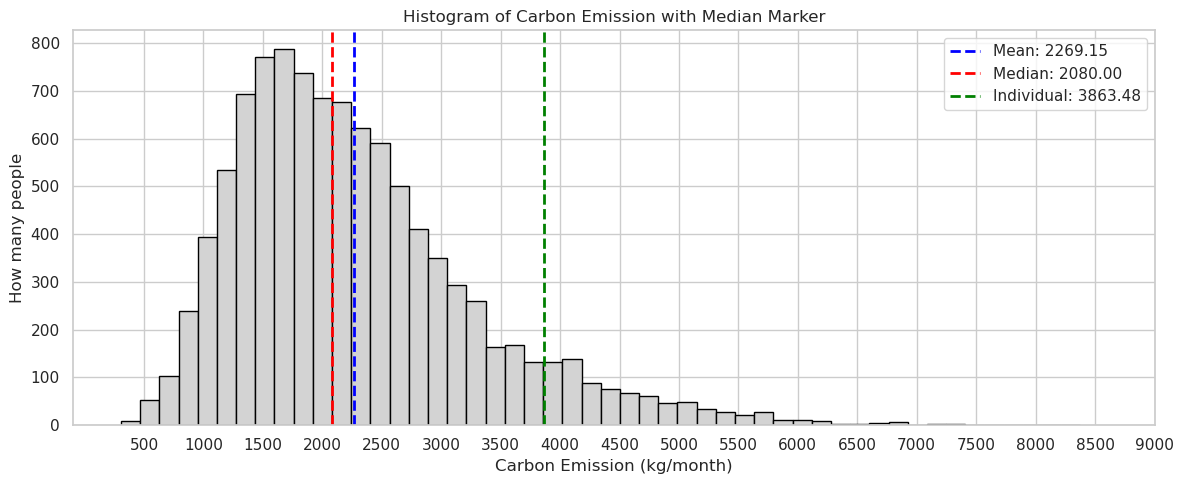

In [24]:
# Final output to the user : Visualize the post recommendation Carbon Emissions of the chosen individual relative to the mean and median of the dataset
# Create Histogram
#plt.subplot(1, 2, 2)  # Histogram
plt.figure(figsize=(12, 5))
plt.hist(df['CarbonEmission'], bins=50, color='lightgray', edgecolor='black')
# add mean as blue line
plt.axvline(df['CarbonEmission'].mean(), color='blue', linestyle='--', label=f'Mean: {mean:.2f}', linewidth=2)
# add median as red line
plt.axvline(median_CE, color='red', linestyle='dashed', label=f'Median: {median_CE:.2f}', linewidth=2)  # Line for the median
# add individual Carbon Emissions as green line
plt.axvline(new_emission, color='green', linestyle='dashed', label=f'Individual: {new_emission:.2f}', linewidth=2)  # Line for the new emission
plt.legend(loc='upper right') 
plt.title('Histogram of Carbon Emission with Median Marker')
plt.xlabel('Carbon Emission (kg/month)')
plt.ylabel('How many people')
plt.xticks(range(500, 9001, 500))  # Set tick positions every 10 units

# Adjust layout and display the plot
plt.tight_layout()
plt.show()